### Alternatives to the Markowitz Portfolio Problem

In [69]:
import sys
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f
import itertools
import  matplotlib.pyplot as plt
path='/home/jbohn/jupyter/personal/L1_Portfolio_Opt/'
sys.path.append(path)

from Features.features import load_features
from Split_Bregman.split_bregman_opt import split_bregman
from Split_Bregman.grid_search import grid_search
from Parameter_Estimation.bias_cov import reg_cov
from Parameter_Estimation.bias_mean import reg_mean

from Portfolio_Optimization.max_var_port import MaxRetPort
from Portfolio_Optimization.min_var_port import MinVarPort
from Portfolio_Optimization.mean_var_port import MeanVarPort, optimize_sharpe

### Prep Data and Features

In [2]:
train_test_split=0.5
train_data, test_data = load_features(train_test_split)
train_data

,MMM,AOS,ABT,ABMD,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WHR,WMB,WTW,GWW,WYNN,XEL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.628321,-1.285971,-0.811210,-2.432083,0.616121,0.176830,0.538743,1.631272,-0.538452,-0.596131,...,-0.207657,1.241682,-0.224387,0.041128,5.904149,-1.193047,-0.342566,-0.174548,3.116535,3.465148
2010-01-06,1.408218,0.045393,0.553813,-1.535767,1.057458,-0.531440,-0.253164,-0.212432,-0.235015,0.868174,...,-0.884311,3.193428,1.597067,0.379627,-1.320395,0.191851,-0.717461,-0.771667,-0.032304,8.338160
2010-01-07,0.071691,0.294622,0.825011,0.000000,-0.093539,-2.427090,-1.051132,-1.959530,-0.047069,-0.024706,...,2.123851,-0.710789,-0.295205,0.937728,2.113119,-0.432174,-0.028805,-2.531778,2.268103,10.616021
2010-01-08,0.702170,1.460205,0.509927,-2.044570,-0.398552,-0.822299,-1.256660,-0.543629,-0.141351,0.394477,...,2.103321,0.799284,-0.110934,1.169962,-0.719055,0.048113,0.028805,-0.325557,-2.122811,-1.631952
2010-01-11,-0.404037,-0.469430,0.507340,-1.839410,-0.094009,-0.091779,0.064831,-1.316890,0.446902,-0.989122,...,-0.640649,-0.621110,0.993936,0.420251,-0.324534,0.957398,1.713344,0.325557,2.185967,0.607538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,0.053927,0.303000,-0.043755,0.338579,-0.109443,0.591430,-0.112905,0.482834,0.082154,-0.597355,...,0.010458,-0.834438,-0.088298,-0.318574,-0.522166,2.232856,0.151239,0.319673,0.562442,-0.035058
2014-12-26,-0.420151,0.762348,0.327685,0.466928,-0.065722,0.343389,0.581993,-0.093701,-0.046938,-0.143644,...,0.677794,0.615528,-0.044178,0.042790,-0.351843,0.961420,0.479675,-0.294066,0.052565,0.140151
2014-12-29,0.270302,0.088268,-0.546748,-0.414938,-0.814182,-0.294259,-0.544341,-0.725811,-0.388069,0.759608,...,0.300925,0.021909,-0.331971,0.686111,1.733903,1.815025,0.572598,-0.064035,-0.588570,0.558660


In [3]:
cov=np.cov(train_data.T)
mean=np.mean(train_data,axis=0).values

biased_cov=reg_cov(train_data)
biased_mean=reg_mean(train_data,train_data.shape[0])


Solved via QP
- Minimum Variance Objective
- Mean Variance Objective
- Mean Variance Objective with Biased Estimators

Solved via Split Bregman
- Mean Variance Objective with Elastic Net Penalty
- Mean Variance Objective with Biased Estimators and Elastic Net Penalty

Solutions to each are for cross-validated optimal parameters for $\lambda_1$ and $\lambda_2$

Unit Box constraints allowing for long-only (0,1)

In [4]:
lb,ub=0.0,0.1
cutoff_threshold=0.01

lambda1_grid=np.geomspace(10e-6,1,5)
lambda2_grid=np.geomspace(10e-6,1,5)

# take all possible combinations of lambda1 and lambda2
params=[]
for i in itertools.product(lambda1_grid,lambda2_grid):
    params.append(i)

### Minimum Variance with Unbiased Sample Estimates

In [5]:
min_var_weights=MinVarPort(cov,max_pos=ub)
min_port_return=np.dot(min_var_weights,mean)
print(f"Minimum variance portfolio return: {round(min_port_return,2)}")

Minimum variance portfolio return: 0.04


Text(0, 0.5, 'Weight')

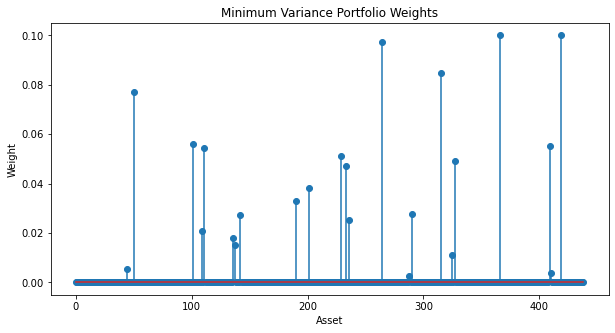

In [6]:
fig,ax=plt.subplots(figsize=(10,5))
ax.set_title("Minimum Variance Portfolio Weights")
ax.stem(min_var_weights)
ax.set_xlabel("Asset")
ax.set_ylabel("Weight")

### Mean Variance with Unbiased Sample Estimates

First need to determine bounds of potential mean-variance portfolios by computing min_var and max_return portfolios 

In [7]:
max_ret_port=MaxRetPort(mean,max_pos=ub)
max_port_return = max_ret_port.dot(mean.T)


print(f"Maximum Return Portfolio Expected Return: {round(max_port_return,2)}")

Maximum Return Portfolio Expected Return: 0.17


Text(0, 0.5, 'Weight')

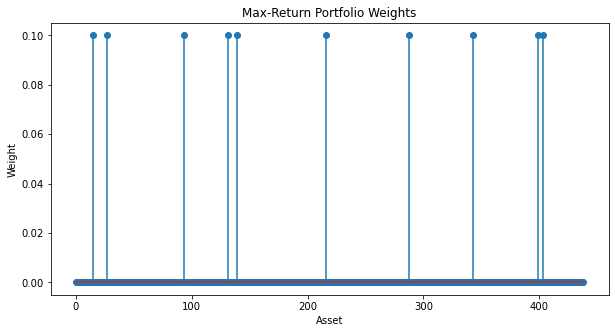

In [8]:
fig,ax=plt.subplots(figsize=(10,5))
ax.set_title("Max-Return Portfolio Weights")
ax.stem(max_ret_port)
ax.set_xlabel("Asset")
ax.set_ylabel("Weight")

### Generate a Sample Efficient Frontier

In [9]:
bounds = [min_port_return, max_port_return]
risk, ret = MeanVarPort(bounds, train_data, num_port=10,verbose=True,)



/home/jbohn/miniconda3/envs/research/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


For expected portfolio return of  0.04
Portfolio Risk:  1.01
Portfolio Return:  0.06

For expected portfolio return of  0.06
Portfolio Risk:  1.09
Portfolio Return:  0.06

For expected portfolio return of  0.07
Portfolio Risk:  1.01
Portfolio Return:  0.07

For expected portfolio return of  0.08
Portfolio Risk:  1.08
Portfolio Return:  0.08

For expected portfolio return of  0.09
Portfolio Risk:  1.15
Portfolio Return:  0.09

For expected portfolio return of  0.11
Portfolio Risk:  1.24
Portfolio Return:  0.11

For expected portfolio return of  0.12
Portfolio Risk:  1.42
Portfolio Return:  0.12

For expected portfolio return of  0.13
Portfolio Risk:  1.42
Portfolio Return:  0.13

For expected portfolio return of  0.15
Portfolio Risk:  1.5
Portfolio Return:  0.15

For expected portfolio return of  0.16
Portfolio Risk:  1.55
Portfolio Return:  0.16

For expected portfolio return of  0.17
Portfolio Risk:  1.64
Portfolio Return:  0.17



### Model True Efficient Frontier for Unbiased Mean Variance Objective using Isotonic Regression

Models our problem using splines

In [97]:
true_eff=LinearGAM(s(0,n_splines=len(risk) ,constraints=['monotonic_inc'])).fit(risk, ret)

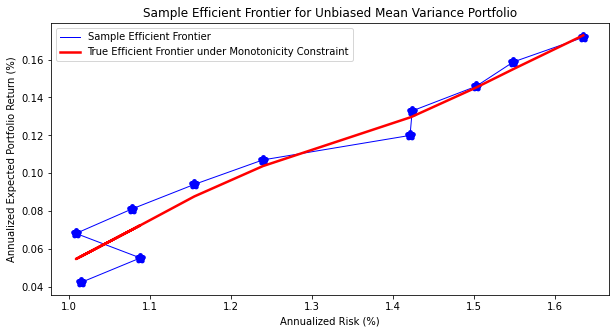

In [98]:
fig,ax=plt.subplots(figsize=(10,5))
plt.title('Sample Efficient Frontier for Unbiased Mean Variance Portfolio')
plt.xlabel('Annualized Risk (%)')
plt.ylabel('Annualized Expected Portfolio Return (%)' )
plt.plot(risk, ret,  c= "blue" , lw=1,label="Sample Efficient Frontier")
plt.plot(risk, true_eff.predict(risk), c= "red" , lw=2.5,label="True Efficient Frontier under Monotonicity Constraint")
plt.scatter(risk, ret, marker='*', c= "blue" , lw=5)
plt.legend()
plt.show()

### Select optimal portfolio by maximization of sharpe ratio

In [10]:
optimal_mean, optimal_std = optimize_sharpe(risk, ret)
print(f"Optimal Mean: {round(optimal_mean,2)}")
print(f"Optimal Std: {round(optimal_std,2)}")


Optimal Mean: 0.17
Optimal Std: 1.64


### Solve for this portfolio of expected return

In [31]:
optimal_mean_var_weights = MinVarPort(cov, mean,fixed_return=optimal_mean,flag= False, max_pos=ub)

/home/jbohn/miniconda3/envs/research/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Text(0, 0.5, 'Weight')

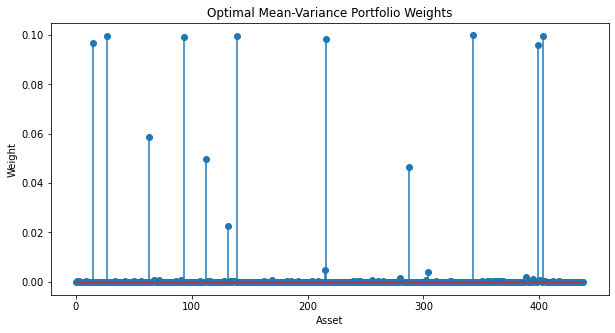

In [32]:
fig,ax=plt.subplots(figsize=(10,5))
ax.set_title("Optimal Mean-Variance Portfolio Weights")
ax.stem(optimal_mean_var_weights)
ax.set_xlabel("Asset")
ax.set_ylabel("Weight")


### Biased Estimators


- $\mu \rightarrow{} \hat{\mu}$
- $\Sigma\rightarrow{} \rho \hat{\Sigma}+(1-\rho)I$

In [13]:
bias_mean=reg_mean(train_data,train_data.shape[0])
bias_cov=reg_cov(train_data)


### Compute Min Var and Max Return Portfolio for Bounds 

In [33]:
min_bias_var_weights=MinVarPort(bias_cov,max_pos=ub)
min_bias_port_return=np.dot(min_bias_var_weights,bias_mean)
print(f"Minimum variance portfolio return: {round(min_bias_port_return,2)}")

Minimum variance portfolio return: 0.04


In [34]:
max_bias_ret_port=MaxRetPort(bias_mean,max_pos=ub)
max_bias_port_return = max_bias_ret_port.dot(bias_mean.T)
print(f"Maximum Return Portfolio Expected Return: {round(max_bias_port_return,2)}")

Maximum Return Portfolio Expected Return: 0.17


### Compute Efficient Frontier off Biased Estimators

In [35]:
biased_bounds=[min_bias_port_return,max_bias_port_return]
biased_risk,biased_ret=MeanVarPort(biased_bounds,train_data,num_port=10,verbose=True)


For expected portfolio return of  0.04
Portfolio Risk:  0.94
Portfolio Return:  0.06

For expected portfolio return of  0.06
Portfolio Risk:  1.07
Portfolio Return:  0.06

For expected portfolio return of  0.07
Portfolio Risk:  1.0
Portfolio Return:  0.07

For expected portfolio return of  0.08
Portfolio Risk:  1.1
Portfolio Return:  0.08

For expected portfolio return of  0.09
Portfolio Risk:  1.16
Portfolio Return:  0.09

For expected portfolio return of  0.11
Portfolio Risk:  1.3
Portfolio Return:  0.11

For expected portfolio return of  0.12
Portfolio Risk:  1.42
Portfolio Return:  0.12

For expected portfolio return of  0.13
Portfolio Risk:  1.49
Portfolio Return:  0.13

For expected portfolio return of  0.15
Portfolio Risk:  1.5
Portfolio Return:  0.15

For expected portfolio return of  0.16
Portfolio Risk:  1.56
Portfolio Return:  0.16

For expected portfolio return of  0.17
Portfolio Risk:  1.63
Portfolio Return:  0.17



### Model True Efficient Frontier under Monotonicty Constraints

In [99]:
true_bias_eff=LinearGAM(s(0,n_splines=len(biased_risk) ,constraints=['monotonic_inc'])).fit(biased_risk, biased_ret)

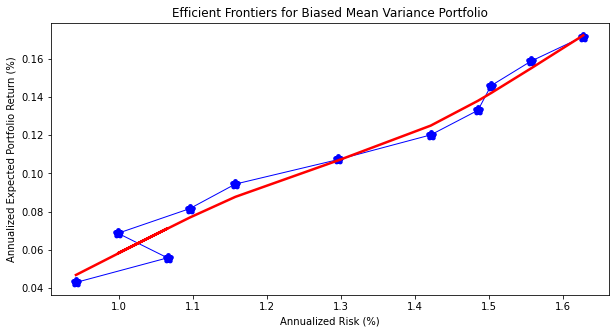

In [100]:
fig,ax=plt.subplots(figsize=(10,5))
plt.title('Efficient Frontiers for Biased Mean Variance Portfolio')
plt.xlabel('Annualized Risk (%)')
plt.ylabel('Annualized Expected Portfolio Return (%)' )
plt.scatter(biased_risk, biased_ret, marker='*', c= "blue" , lw=5)
plt.plot(biased_risk, biased_ret,  c= "blue" , lw=1)
plt.plot(biased_risk, true_bias_eff.predict(biased_risk), c= "red" , lw=2.5)
plt.show()

### Comparison of True Efficient Frontiers 

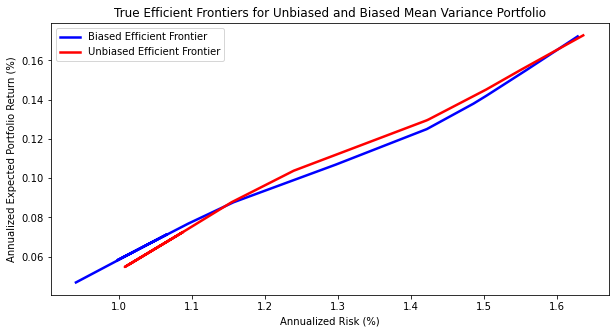

In [104]:
fig,ax=plt.subplots(figsize=(10,5))
plt.title('True Efficient Frontiers for Unbiased and Biased Mean Variance Portfolio')
plt.xlabel('Annualized Risk (%)')
plt.ylabel('Annualized Expected Portfolio Return (%)' )

plt.plot(biased_risk, true_bias_eff.predict(biased_risk), c= "blue" , lw=2.5,label="Biased Efficient Frontier")
plt.plot(risk, true_eff.predict(risk), c= "red" , lw=2.5,label="Unbiased Efficient Frontier")
plt.legend()
plt.show()

### Select Optimal Portfolio with Biased Estimators

In [36]:
biased_optimal_mean,biased_optimal_std=optimize_sharpe(biased_risk,biased_ret)
print(f"Optimal Mean: {round(biased_optimal_mean,2)}")
print(f"Optimal Std: {round(biased_optimal_std,2)}")

Optimal Mean: 0.17
Optimal Std: 1.63


### Solve Optimal Biased Estimators Portfolio

In [37]:
optimal_bias_portfolio=MinVarPort(bias_cov,bias_mean,fixed_return=biased_optimal_mean,flag=False,max_pos=ub)


Text(0, 0.5, 'Weight')

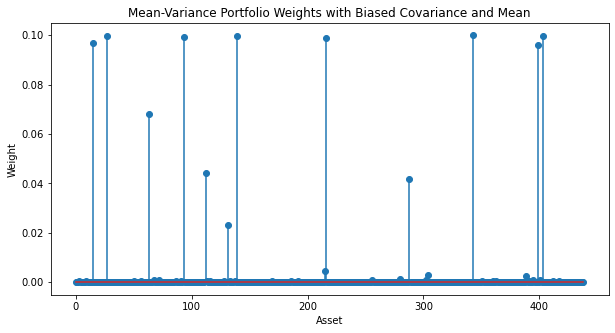

In [38]:
fig,ax=plt.subplots(figsize=(10,5))
ax.set_title("Mean-Variance Portfolio Weights with Biased Covariance and Mean")
ax.stem(optimal_bias_portfolio)
ax.set_xlabel("Asset")
ax.set_ylabel("Weight")

### Elastic Net Penalty Unbiased Sample Estimates 

In [20]:
sorted_dict=grid_search(params,mean,cov,optimal_mean)


 lambda1: 1e-05 lambda2: 1e-05 error: 0.08324994
 lambda1: 1e-05 lambda2: 0.00017783 error: 0.08329866
 lambda1: 1e-05 lambda2: 0.00316228 error: 0.08538705
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 1e-05 and lambda2: 0.05623413251903491
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 1e-05 and lambda2: 1.0
 lambda1: 0.00017783 lambda2: 1e-05 error: 0.08391582
 lambda1: 0.00017783 lambda2: 0.00017783 error: 0.08396529
 lambda1: 0.00017783 lambda2: 0.00316228 error: 0.08609002
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 0.00017782794100389227 and lambda2: 0.05623413251903491
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 0.00017782794100389227 and lambda2: 1.0
 lambda1: 0.00316228 lambda2: 1e-05 error: 0.09575689
 lambda1: 0.00316228 lambda2: 0.00017783 error: 0.09581988
 lambda1: 0.00316228 lambda2: 0.00316228 error: 0.09859083
QP Optimizati

In [21]:
optimal_lambda1,optimal_lambda2=sorted_dict[0][0][0],sorted_dict[1][0][1]

print(f" Optimal lambda1: {optimal_lambda1} Optimal lambda2: {optimal_lambda2} with error: {sorted_dict[0][1][1]} and Expected return: {optimal_mean}")
w_sb_unbias,w_sb_unbias_err,status_sb_unbias=split_bregman(cov=cov,mean=mean,lambda1=optimal_lambda1,lambda2=optimal_lambda2,fixed_return=optimal_mean,lb=lb,ub=ub,tol=1e-8,maxiter=25,approach="closed-form",verbose=True)

 Optimal lambda1: 1e-05 Optimal lambda2: 0.00017782794100389227 with error: 0.08324994427629122 and Expected return: 0.1717086047290301
Total Cost: 0.3205090703828195
Total Cost: 0.32050911255946346
Total Cost: 0.3205091547580137
Total Cost: 0.3205091969784687
Total Cost: 0.32050923922082675
Total Cost: 0.3205092814850863
Total Cost: 0.32050932377124575
Total Cost: 0.3205093660793029
Total Cost: 0.3205094084092552
Total Cost: 0.3205094507611014
Total Cost: 0.3205094931348384
Total Cost: 0.3205095355304642
Total Cost: 0.32050957794797585
Total Cost: 0.32050962038737063
Total Cost: 0.3205096628486463
Total Cost: 0.32050970533179896
Total Cost: 0.3205097478368261
Total Cost: 0.3205097903637243
Total Cost: 0.32050983291248974
Total Cost: 0.3205098754831193
Total Cost: 0.3205099180756091
Total Cost: 0.3205099606899551
Total Cost: 0.32051000332615326
Total Cost: 0.32051004598419963
Total Cost: 0.3205100886640892
Total Cost: 0.32051013136581785
MaxIter Achieved


Text(0, 0.5, 'Weight')

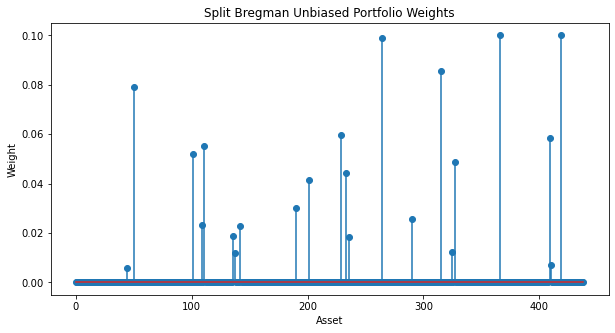

In [22]:
fig,ax=plt.subplots(figsize=(10,5))
ax.set_title("Split Bregman Unbiased Portfolio Weights")
ax.stem(w_sb_unbias)

ax.set_xlabel("Asset")
ax.set_ylabel("Weight")

### Elastic Net Penalty with Biased Estimates

In [23]:
bias_sorted_dict=grid_search(params,biased_mean,biased_cov,biased_optimal_mean,tol=10e-6,maxiter=25)


 lambda1: 1e-05 lambda2: 1e-05 error: 0.07041739
 lambda1: 1e-05 lambda2: 0.00017783 error: 0.07042041
 lambda1: 1e-05 lambda2: 0.00316228 error: 0.07047417
 lambda1: 1e-05 lambda2: 0.05623413 error: 0.07148754
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 1e-05 and lambda2: 1.0
 lambda1: 0.00017783 lambda2: 1e-05 error: 0.07061153
 lambda1: 0.00017783 lambda2: 0.00017783 error: 0.07061454
 lambda1: 0.00017783 lambda2: 0.00316228 error: 0.0706683
 lambda1: 0.00017783 lambda2: 0.05623413 error: 0.07168162
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 0.00017782794100389227 and lambda2: 1.0
 lambda1: 0.00316228 lambda2: 1e-05 error: 0.07406377
 lambda1: 0.00316228 lambda2: 0.00017783 error: 0.07406678
 lambda1: 0.00316228 lambda2: 0.00316228 error: 0.0741205
 lambda1: 0.00316228 lambda2: 0.05623413 error: 0.07513295
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 0.003162277660168379

In [24]:
optimal_bias_lambda1,optimal_bias_lambda2=bias_sorted_dict[0][0][0],bias_sorted_dict[1][0][1]

print(f" Optimal lambda1: {optimal_bias_lambda1} Optimal lambda2: {optimal_bias_lambda2} with error: {bias_sorted_dict[0][1][1]} and Expected return: {biased_optimal_mean}")
w_sb_bias,w_sb_bias_err,status_sb_bias=split_bregman(cov=biased_cov,mean=biased_mean,lambda1=optimal_bias_lambda1,lambda2=optimal_bias_lambda2,fixed_return=biased_optimal_mean,lb=lb,ub=ub,tol=1e-8,maxiter=25,approach="closed-form",verbose=True)

 Optimal lambda1: 1e-05 Optimal lambda2: 0.00017782794100389227 with error: 0.07041739397965108 and Expected return: 0.20169294601251647
Total Cost: 0.11326660882285557
Total Cost: 0.11326662860444685
Total Cost: 0.1132666483876256
Total Cost: 0.11326666817239207
Total Cost: 0.11326668795874682
Total Cost: 0.11326670774668998
Total Cost: 0.11326672753622191
Total Cost: 0.11326674732734279
Total Cost: 0.11326676712005337
Total Cost: 0.11326678691435366
Total Cost: 0.1132668067102439
Total Cost: 0.1132668265077247
Total Cost: 0.1132668463067963
Total Cost: 0.11326686610745909
Total Cost: 0.11326688590971322
Total Cost: 0.11326690571355912
Total Cost: 0.11326692551899732
Total Cost: 0.11326694532602802
Total Cost: 0.11326696513465159
Total Cost: 0.11326698494486832
Total Cost: 0.11326700475667872
Total Cost: 0.11326702457008295
Total Cost: 0.11326704438508158
Total Cost: 0.11326706420167476
Total Cost: 0.11326708401986323
Total Cost: 0.11326710383964689
MaxIter Achieved


Text(0, 0.5, 'Weight')

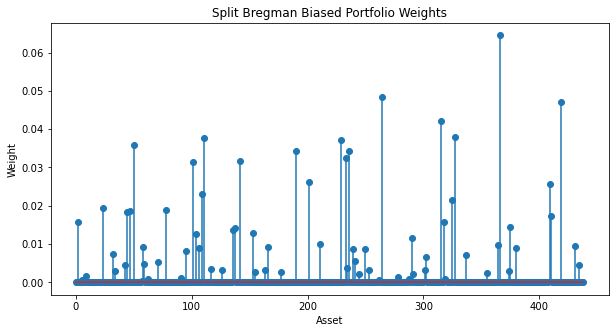

In [25]:
fig,ax=plt.subplots(figsize=(10,5))
ax.set_title("Split Bregman Biased Portfolio Weights")
ax.stem(w_sb_bias)
ax.set_xlabel("Asset")
ax.set_ylabel("Weight")


### Out of Sample Performance 

In [26]:
test_data.T/100

Date,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,...,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-26,2019-12-27,2019-12-30,2019-12-31
MMM,-0.001584,-0.022811,-0.010721,0.007223,0.023685,-0.012360,-0.005460,-0.000747,-0.004868,-0.001127,...,-0.004814,-0.005310,0.018290,0.018532,0.017523,-0.010080,-0.000510,0.003787,-0.008100,0.003350
AOS,-0.007116,-0.017652,-0.008211,0.007302,0.025677,-0.016083,0.003955,-0.004316,-0.002526,-0.020442,...,0.013334,0.006813,0.004657,0.001477,-0.005922,0.007608,0.005040,0.001465,-0.005033,0.001470
ABT,-0.002669,0.000223,-0.011421,0.008075,0.020346,-0.010563,0.008372,-0.021511,-0.007425,-0.007480,...,0.007610,-0.001494,0.004820,-0.007931,0.007931,-0.000802,0.000000,0.001374,-0.006889,0.000691
ABMD,-0.019902,-0.006453,-0.025684,0.031333,0.044078,-0.014218,0.003898,0.006462,-0.014534,-0.030257,...,0.014751,-0.010788,-0.043766,-0.039365,0.045308,0.010854,-0.007515,-0.010227,-0.011766,0.019534
ACN,-0.005276,-0.017028,-0.007239,0.020772,0.015134,-0.001113,-0.003012,0.003569,-0.011758,-0.006895,...,-0.007836,0.011536,0.012269,0.013353,-0.001280,0.003693,0.002077,0.000801,-0.007473,-0.000332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XEL,0.005553,-0.011416,0.005307,0.008598,0.011532,-0.012361,-0.008884,0.008055,0.008813,0.008736,...,0.006799,0.005187,0.000940,0.004688,-0.017772,-0.002542,-0.001114,0.005242,0.002690,0.003155
YUM,-0.006887,-0.020527,-0.012350,0.032601,0.017270,-0.001768,-0.007515,-0.004123,-0.004140,-0.011965,...,-0.012668,-0.008873,0.010878,0.007684,-0.007784,0.005196,0.014447,0.001080,-0.012442,0.000894
ZBRA,0.000258,-0.014177,-0.007231,0.025146,0.021134,0.014508,0.001489,0.023040,-0.015998,0.000615,...,-0.007900,0.007821,-0.009045,-0.002532,0.016653,-0.009392,0.000354,0.006191,-0.007410,0.005220
ZBH,-0.007345,0.036625,-0.008513,0.024566,0.010561,-0.014529,0.002366,0.002192,-0.013309,-0.018953,...,-0.000934,-0.006561,-0.000537,0.010163,0.006102,-0.002449,-0.003785,-0.001931,-0.008435,0.006233


Text(0, 0.5, 'Cumulative Returns')

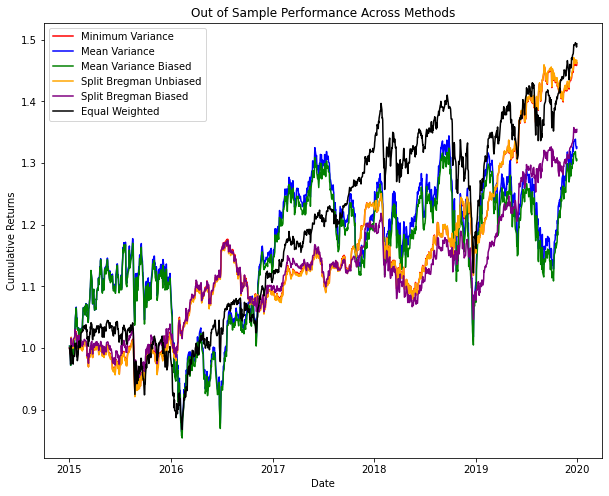

In [42]:
cum_returns_1=np.cumprod(1+np.dot(min_var_weights,test_data.T/100))
cum_returns_2=np.cumprod(1+np.dot(optimal_mean_var_weights,test_data.T/100))
cum_returns_3=np.cumprod(1+np.dot(optimal_bias_portfolio,test_data.T/100))
cum_returns_4=np.cumprod(1+np.dot(w_sb_unbias,test_data.T/100))
cum_returns_5=np.cumprod(1+np.dot(w_sb_bias,test_data.T/100))

cum_returns_equal=np.cumprod(1+np.dot(np.ones(len(mean))/len(mean),test_data.T/100))


fig,ax=plt.subplots(figsize=(10,8))
plt.title("Out of Sample Performance Across Methods")
plt.plot(pd.to_datetime(test_data.index),cum_returns_1,label='Minimum Variance',color='red')
plt.plot(pd.to_datetime(test_data.index),cum_returns_2,label='Mean Variance',color='blue')
plt.plot(pd.to_datetime(test_data.index),cum_returns_3,label='Mean Variance Biased',color='green')
plt.plot(pd.to_datetime(test_data.index),cum_returns_4,label='Split Bregman Unbiased',color='orange')
plt.plot(pd.to_datetime(test_data.index),cum_returns_5,label='Split Bregman Biased',color='purple')
plt.plot(pd.to_datetime(test_data.index),cum_returns_equal,label='Equal Weighted',color='black')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")


In [40]:
def get_sharpe(port_returns,rf=0.025):
    de_meaned_returns=port_returns-1
    
    sd=np.std(de_meaned_returns-rf)
    mu=np.mean(de_meaned_returns)
    
    sharpe=(mu-rf)/sd
    
    return np.round(sharpe,4)

In [41]:
sharpe_1=get_sharpe(cum_returns_1)
sharpe_2=get_sharpe(cum_returns_2)
sharpe_3=get_sharpe(cum_returns_3)
sharpe_4=get_sharpe(cum_returns_4)
sharpe_5=get_sharpe(cum_returns_5)
sharpe_equal=get_sharpe(cum_returns_equal)

print(f"Minimum Variance Sharpe: {sharpe_1}")
print(f"Mean Variance Sharpe: {sharpe_2}")
print(f"Mean Variance Biased Sharpe: {sharpe_3}")

print(f"Split Bregman Unbiased Sharpe: {sharpe_4}")
print(f"Split Bregman Biased Sharpe: {sharpe_5}")
print(f"Equal Weighted Sharpe: {sharpe_equal}")


Minimum Variance Sharpe: 0.9384
Mean Variance Sharpe: 1.3311
Mean Variance Biased Sharpe: 1.2608
Split Bregman Unbiased Sharpe: 0.9248
Split Bregman Biased Sharpe: 1.0719
Equal Weighted Sharpe: 1.0313
